In [ ]:
# from google.colab import drive
# import shutil
# drive.mount('/content/drive')
# shutil.copyfile("/content/drive/MyDrive/compas_again/compas_processing.py", "compas_processing.py")

Mounted at /content/drive


'compas_processing.py'

In [ ]:
# Initialization
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from compas_processing import process_dataframe, split_temporal
import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_columns', None)
# torch.set_default_tensor_type("torch.cuda.FloatTensor")
# COMPAS dataset
raw_df = pd.read_csv('https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv')
raw_df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [ ]:
train_df, val_df, test_df = split_temporal(raw_df, time="compas_screening_date", train_split=0.8, val_split=0.1)

In [ ]:
train_data = process_dataframe(train_df)  # x, sens, y
valid_data = process_dataframe(val_df)
test_data = process_dataframe(test_df)
print(train_data[0].shape, train_data[1].shape, train_data[2].shape, valid_data[0].shape, test_data[0].shape)

torch.Size([5771, 15]) torch.Size([5771]) torch.Size([5771]) torch.Size([722, 15]) torch.Size([721, 15])


In [ ]:
class ChildNetwork(nn.Module):
  def __init__(self, inpt_size, outpt_size, layers, act_funcs, thresholds):
    super().__init__()
    self.layers = layers  # hidden layer sizes
    self.thresholds = thresholds
    assert (len(act_funcs) == len(layers) + 1)
    assert (act_funcs[-1] == "sigmoid")
    self.act_funcs = [getattr(torch.nn.functional, act_name) for act_name in act_funcs]
    sizes = [inpt_size] + self.layers + [outpt_size]
    self.weights = nn.ModuleList([nn.Linear(size_prev, size) for size_prev, size in zip(sizes, sizes[1:])])

  def forward(self, x):
    for w, act_func in zip(self.weights, self.act_funcs):
      x = act_func(w(x))
    return x.squeeze()

  def _classify(self, logits, sensitive_trait):
    threshold = torch.gather(self.thresholds, 0, sensitive_trait)
    #print(threshold.shape)
    classif = logits >= threshold
    #print(logits.shape)
    return classif

  def classify(self, x, sensitive_trait):
    logits = self.forward(x)
    return self._classify(logits, sensitive_trait)

  def counter_factual(self, x, sensitive_trait, transforms):
    classif_probs = []
    for transform in transforms:
      classifs = self.classify(*transform(x, sensitive_trait))
      classif_probs.append((classifs.sum()/classifs.shape[0]).detach().cpu())
    return np.std(classif_probs)

  def _accuracy(self, classifs, y):
    correct_pct = (classifs == y).sum()/(classifs.shape[0])
    #print(classifs.shape, y.shape)
    return correct_pct

  def accuracy(self, x, y, sensitive_trait):
    classifs = self.classify(x, sensitive_trait)
    return self._accuracy(classifs, y)

In [ ]:
class Controller(nn.Module):
  def __init__(self, num_thresholds, num_categs, hidden_size):
    # we predict each theshold
    super().__init__()
    self.num_outputs = num_thresholds + 2
    self.num_categs = num_categs
    self.hidden_size = hidden_size

    self.inpt_layer = nn.Linear(num_categs, hidden_size)
    self.hidden_layer = nn.Linear(hidden_size, hidden_size)
    self.tanh_hidden = torch.nn.Tanh()
    self.output_layer = nn.Linear(hidden_size, num_categs)
    self.softmax_out = torch.nn.Softmax()

  def run_once(self, hidden, x):
      hidden = self.tanh_hidden(self.hidden_layer(hidden) + self.inpt_layer(x))
      outpt = self.softmax_out(self.output_layer(hidden))
      return hidden, outpt

  def forward(self, x):
    # input is all zeros vector
    hidden = torch.zeros(self.hidden_size)
    outputs = []
    hiddens = []
    for _ in range(self.num_outputs):
      hidden, x = self.run_once(hidden, x)
      outputs.append(x.clone())
      hiddens.append(hidden.clone())
    return outputs, hiddens

  def _select_params(self, init_gen):
    results, _ = self(init_gen)
    threshs_chosen = []
    hiddens_chosen = []
    for res in results[:-2]:
        threshs_chosen.append(res.argmax()/10.)

    for res in results[-2:]:
      hiddens_chosen.append((res.argmax()+1)*8)
    return threshs_chosen, hiddens_chosen, init_gen

  def select_params(self):
    x = (2.*torch.rand(self.num_categs)-1)/20
    return self._select_params(x)

  def update(self, init_gen, optim, reward, prev_reward):
    hidden = torch.zeros(self.hidden_size)
    x_inpt = init_gen
    for _ in range(self.num_outputs):
      hidden, x = self.run_once(hidden, x_inpt)
      hidden = hidden.clone().detach()
      x_inpt = x.clone().detach()
      objective = -torch.log(x.max()) * (reward - prev_reward)  # want to maximize this, not minimize, so multipliy by -1?
      objective.backward()
      optim.step()
      optim.zero_grad()

In [ ]:
def transform_general(i):
  race = 3 + i % 6
  sex = i // 6
  def transf(data, sens):
    data = data.clone()
    sens = sens.clone()
    data[:, 3:9] = 0 # set all races to 0
    data[:, race] = 1
    data[:, 0] = sex
    sens[0:] = i
    return data, sens
  return transf

all_transforms = [transform_general(i) for i in range (12)]

In [ ]:
def train(model, optim, tr_data, va_data, loss_fn, epochs, logging=True):
  train_loss_list = []
  va_losses = []
  va_counterfacts = []
  va_accs = []
  for epoch in range(epochs):
    model.train() # set to training mode

    preds = model(tr_data[0])
    epoch_loss = loss_fn(preds, tr_data[2])
    epoch_loss.backward()
    optim.step()
    optim.zero_grad()
    train_loss_list.append(float(epoch_loss.item()))
        
    model.eval()  # set to evaluation mode
    va_preds = model(va_data[0])

    va_loss = float(loss_fn(va_preds, va_data[2]).item())
    va_acc = float(model._accuracy(model._classify(va_preds, va_data[1]), va_data[2]).item())
    va_counter_fact = model.counter_factual(va_data[0], va_data[1], all_transforms)

    va_losses.append(va_loss)
    va_accs.append(va_acc)
    va_counterfacts.append(va_counter_fact)
    
    if logging:
      print(f"Epoch {epoch}: loss:{va_loss:.4f}, acc:{va_acc:.2f}, counter_fact:{va_counter_fact:.3f}")
      
  if logging:
    fig, (ax1, ax2, ax3) = plt.subplots(3)
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax1.plot(train_loss_list,label="Train Loss", color="#cc6462")
    ax1.plot(va_losses, label="Valid Loss", color="#9e9e9e") 
    ax1.set(xlabel="Iterations", ylabel="Losses")  
    ax1.set_title("Training and Validation Losses")
    ax1.legend()
    
    ax2.plot(va_counterfacts, color="#cc6462")
    ax2.set(ylabel="Counterfactual Std")
    ax2.set_title("Validation Counterfactual Std")

    ax3.plot(va_accs, color="#cc6462")
    ax3.set(ylabel="Validation Accuracy")
    ax3.set_title("Validation Accuracy")

    plt.show()
  return va_acc, va_counter_fact

In [ ]:
LAYERS = [50, 50]
ACT_FUNCS = ["relu", "relu", "sigmoid"]
thresholds = torch.tensor([0.5]*12)
child = ChildNetwork(15, 1, LAYERS, ACT_FUNCS, thresholds)
optimizer = torch.optim.Adam(child.parameters())

def loss_fn(x, y):
  return nn.functional.binary_cross_entropy(x.squeeze(), y)


Epoch 0: loss:0.7486, acc:0.34, counter_fact:0.253
Epoch 1: loss:0.7361, acc:0.39, counter_fact:0.000
Epoch 2: loss:0.7479, acc:0.41, counter_fact:0.001
Epoch 3: loss:0.7779, acc:0.41, counter_fact:0.000
Epoch 4: loss:0.8163, acc:0.41, counter_fact:0.000
Epoch 5: loss:0.8528, acc:0.41, counter_fact:0.000
Epoch 6: loss:0.8786, acc:0.41, counter_fact:0.000
Epoch 7: loss:0.8896, acc:0.41, counter_fact:0.000
Epoch 8: loss:0.8863, acc:0.41, counter_fact:0.000
Epoch 9: loss:0.8720, acc:0.41, counter_fact:0.001
Epoch 10: loss:0.8506, acc:0.41, counter_fact:0.000
Epoch 11: loss:0.8261, acc:0.41, counter_fact:0.001
Epoch 12: loss:0.8021, acc:0.41, counter_fact:0.001
Epoch 13: loss:0.7818, acc:0.41, counter_fact:0.001
Epoch 14: loss:0.7674, acc:0.41, counter_fact:0.002
Epoch 15: loss:0.7584, acc:0.41, counter_fact:0.003
Epoch 16: loss:0.7531, acc:0.40, counter_fact:0.004
Epoch 17: loss:0.7480, acc:0.41, counter_fact:0.008
Epoch 18: loss:0.7404, acc:0.41, counter_fact:0.010
Epoch 19: loss:0.7305,

Epoch 185: loss:0.7044, acc:0.58, counter_fact:0.040
Epoch 186: loss:0.7041, acc:0.58, counter_fact:0.040
Epoch 187: loss:0.7041, acc:0.58, counter_fact:0.041
Epoch 188: loss:0.7042, acc:0.58, counter_fact:0.041
Epoch 189: loss:0.7040, acc:0.58, counter_fact:0.041
Epoch 190: loss:0.7039, acc:0.58, counter_fact:0.041
Epoch 191: loss:0.7040, acc:0.58, counter_fact:0.041
Epoch 192: loss:0.7042, acc:0.58, counter_fact:0.042
Epoch 193: loss:0.7040, acc:0.58, counter_fact:0.042
Epoch 194: loss:0.7040, acc:0.58, counter_fact:0.042
Epoch 195: loss:0.7042, acc:0.58, counter_fact:0.042
Epoch 196: loss:0.7041, acc:0.58, counter_fact:0.042
Epoch 197: loss:0.7038, acc:0.58, counter_fact:0.043
Epoch 198: loss:0.7038, acc:0.58, counter_fact:0.043
Epoch 199: loss:0.7040, acc:0.58, counter_fact:0.043


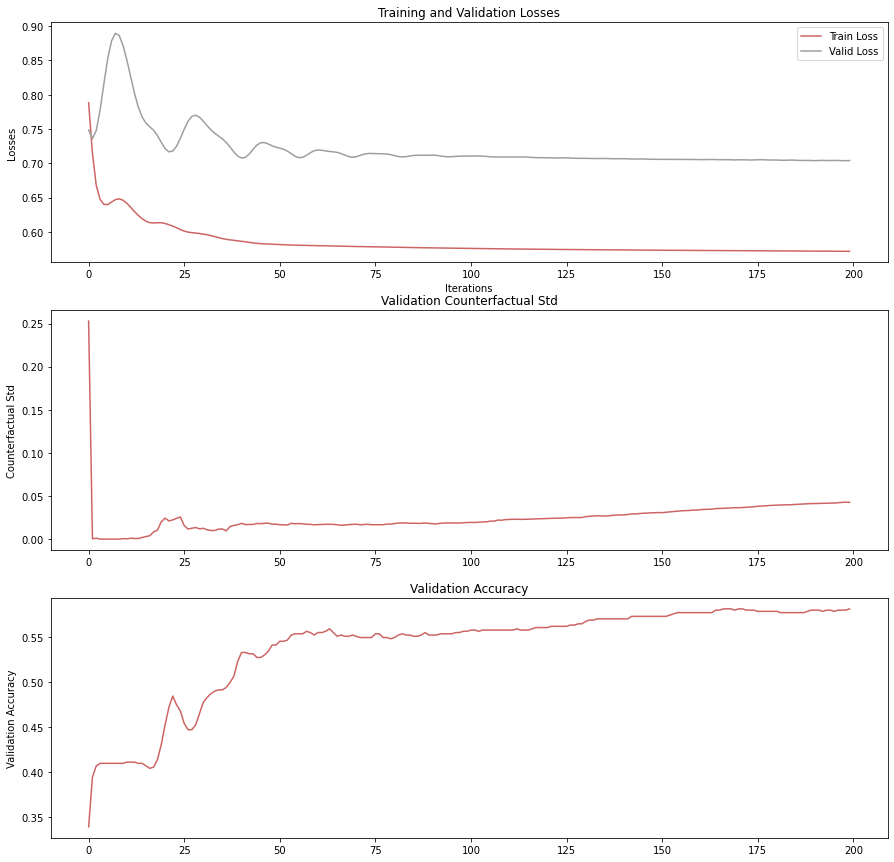

(0.5817174315452576, 0.04272899)

In [ ]:
train(child, optimizer, train_data, valid_data, loss_fn, 200)

In [ ]:
ACT_FUNCS = ["relu", "relu", "sigmoid"]
controller = Controller(12, 10, 100)
ctrl_optim = torch.optim.Adam(controller.parameters())
all_results = []
for i in tqdm(range(1500)):
  init_gens = []
  rewards = []
  ewma_reward = 0
  gamma = 0.3

  for j in range(3):
    threshs, hiddens, init_gen = controller.select_params()
    child = ChildNetwork(15, 1, hiddens, ACT_FUNCS, torch.tensor(threshs))
    chld_optim = torch.optim.Adam(child.parameters())
    final_va_acc, final_va_counter_fact = train(child, chld_optim, train_data, valid_data, loss_fn, 150, logging=False)

    reward = final_va_acc + final_va_counter_fact*3.0
    init_gens.append(init_gen.clone().detach())
    rewards.append(reward)
    ewma_reward = gamma*reward + (1-gamma)*ewma_reward
    all_results.append((final_va_acc, final_va_counter_fact, threshs.copy(), hiddens.copy()))
  
  for init_gen, reward in zip(init_gens, rewards):
    controller.update(init_gen, ctrl_optim, reward, ewma_reward)



  0%|                                                                                                                                                           | 0/1500 [00:00<?, ?it/s]/tmp/ipykernel_7060/3429537883.py:17: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outpt = self.softmax_out(self.output_layer(hidden))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1500/1500 [34:07<00:00,  1.36s/it]


In [ ]:
min(all_results, key=lambda it: it[1])  
# (0.6814404129981995,
#  0.01300667,
#  [tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000),
#   tensor(0.2000)],
#  [tensor(24), tensor(24)])

(0.6814404129981995,
 0.01300667,
 [tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000),
  tensor(0.2000)],
 [tensor(24), tensor(24)])

In [ ]:
max(all_results, key=lambda it: it[0])

(0.6495844721794128,
 0.020173103,
 [tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000),
  tensor(0.1000)],
 [tensor(16), tensor(16)])

Epoch 0: loss:0.7641, acc:0.62, counter_fact:0.000
Epoch 1: loss:0.7796, acc:0.62, counter_fact:0.000
Epoch 2: loss:0.7940, acc:0.62, counter_fact:0.000
Epoch 3: loss:0.8067, acc:0.62, counter_fact:0.000
Epoch 4: loss:0.8174, acc:0.62, counter_fact:0.000
Epoch 5: loss:0.8259, acc:0.62, counter_fact:0.000
Epoch 6: loss:0.8320, acc:0.62, counter_fact:0.000
Epoch 7: loss:0.8359, acc:0.61, counter_fact:0.000
Epoch 8: loss:0.8379, acc:0.61, counter_fact:0.000
Epoch 9: loss:0.8382, acc:0.61, counter_fact:0.000
Epoch 10: loss:0.8373, acc:0.61, counter_fact:0.001
Epoch 11: loss:0.8356, acc:0.61, counter_fact:0.000
Epoch 12: loss:0.8333, acc:0.61, counter_fact:0.000
Epoch 13: loss:0.8307, acc:0.61, counter_fact:0.000
Epoch 14: loss:0.8279, acc:0.61, counter_fact:0.001
Epoch 15: loss:0.8251, acc:0.62, counter_fact:0.001
Epoch 16: loss:0.8222, acc:0.62, counter_fact:0.000
Epoch 17: loss:0.8195, acc:0.62, counter_fact:0.001
Epoch 18: loss:0.8169, acc:0.62, counter_fact:0.001
Epoch 19: loss:0.8144,

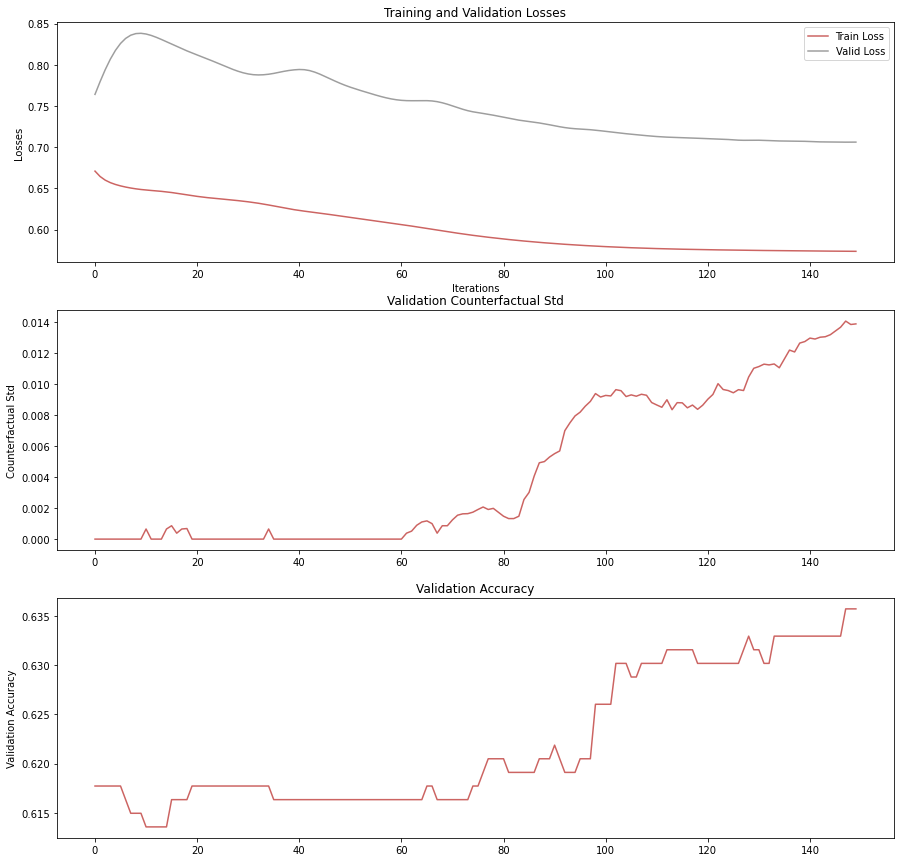

(0.6357340812683105, 0.013901775)

In [ ]:
LAYERS = [16, 16]
ACT_FUNCS = ["relu", "relu", "sigmoid"]
thresholds = torch.tensor([0.1]*12)
child = ChildNetwork(15, 1, LAYERS, ACT_FUNCS, thresholds)
optimizer = torch.optim.Adam(child.parameters())
train(child, optimizer, train_data, valid_data, loss_fn, 150)